In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))
 
#여백 줄이기
display(HTML("<style>.prompt { min-width: 1ex !important; }</style>"))
 
#In 부분 없애기
#display(HTML("<style>.prompt bdi { display:none !important; }</style>"))
 
#아예 다 없애기
#display(HTML("<style>.prompt { display:none !important; }</style>"))

C:\Users\yunjc\AppData\Local\Temp\ipykernel_14056\3274554136.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

# Data Load
---

In [15]:
import os
os.getcwd()

'c:\\Users\\yunjc\\_python_jupyter\\Project_DA\\Lpoint_competition\\domain_clustering'

In [9]:
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")

df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")

C:\Users\yunjc\AppData\Local\Temp\ipykernel_14056\1956657325.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")


# 함수화
---

In [10]:
# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])

# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_res1 = df.loc[df[col_nm]==1] ##off
    df_res2 = df.loc[df[col_nm]==2] ##on
    df_res3 = df.loc[df[col_nm]==0] ##onf
    return df_res1, df_res2, df_res3 #off, on, onf

# loyal/unloyal 분류
def split_loyal(df_main, df_sub, col_nm ='rct_no', key = 'cust'):
    df_rct_no = pd.DataFrame(df_sub.groupby([key])[col_nm].apply(lambda x: len(list(set(x))))).reset_index()
    df_m2 = df_main.merge(df_rct_no, how="left", on=key)
    df_loyal = df_m2.loc[df_m2[col_nm]>3]
    df_unloyal = df_m2.loc[df_m2[col_nm]<=3]
    return df_loyal, df_unloyal

# vip/unvip 분류
def split_vip(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    df_vip = df_m2.loc[df_m2[col_nm]>200000]
    df_unvip = df_m2.loc[df_m2[col_nm]<=200000]
    return df_vip, df_unvip

##unloyal Nan 문제 해결
def unloyal_buy_am_solve(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    return df_m2


def domain_clustering(df_main, df_sub):
    df = check_on_off(df_main, df_sub)

    df_off, df_on, df_onf = split_on_off(df)

    df_01, df_2 = split_loyal(df_on, df_sub)
    df_34, df_5 = split_loyal(df_onf, df_sub)
    df_67, df_8 = split_loyal(df_off, df_sub)

    df_0, df_1 = split_vip(df_01, df_sub)
    df_3, df_4 = split_vip(df_34, df_sub)
    df_6, df_7 = split_vip(df_67, df_sub)
    
    df_2 = unloyal_buy_am_solve(df_2, df_sub)
    df_5 = unloyal_buy_am_solve(df_5, df_sub)
    df_8 = unloyal_buy_am_solve(df_8, df_sub)
    
    df_init = pd.DataFrame()
    for i, df_temp in enumerate([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]):
        df_temp["cluster"] = i
        df_init = pd.concat([df_init, df_temp], axis=0, ignore_index=True)
        
    return df_init


In [11]:
result = domain_clustering(df_cust, df_pdde)

In [12]:
result

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
0,M001248380,여성,30대,Z10,2,38,992100.0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0
...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8
26913,M996679486,여성,40대,Z16,1,2,14180.0,8
26914,M997482914,여성,40대,Z03,1,2,64000.0,8
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8


In [16]:
result[['cust', 'cluster']].to_csv('domain_cluster_result.csv', index=False)

In [17]:
result[['cust', 'cluster']]

,cust,cluster
0,M001248380,0
1,M006962764,0
2,M008864908,0
3,M014792007,0
4,M021341630,0
...,...,...
26912,M996092967,8
26913,M996679486,8
26914,M997482914,8
26915,M999340261,8


In [18]:
result[result["chnl_dv"]==0] # 온오프

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
890,M000136117,여성,30대,Z11,0,70,27373630.0,3
891,M000494848,여성,30대,Z10,0,160,25624610.0,3
892,M000621637,여성,40대,Z11,0,137,16702330.0,3
893,M000986912,여성,30대,Z10,0,48,777430.0,3
894,M001332751,여성,30대,Z06,0,33,2814069.0,3
...,...,...,...,...,...,...,...,...
9461,M975506549,남성,30대,Z17,0,2,131900.0,5
9462,M983748971,여성,30대,Z10,0,3,21900.0,5
9463,M986339107,여성,30대,Z10,0,2,1066000.0,5
9464,M987624864,남성,30대,Z14,0,2,62080.0,5


# Visualization
---

## on-line / off-line / on&off-line

In [19]:
result_onoff = result[result["chnl_dv"]==0] #온오프
result_off = result[result["chnl_dv"]==1] #오프
result_on = result[result["chnl_dv"]==2] #온

온라인, 오프라인, 온라인_오프라인을 구분하는 이유

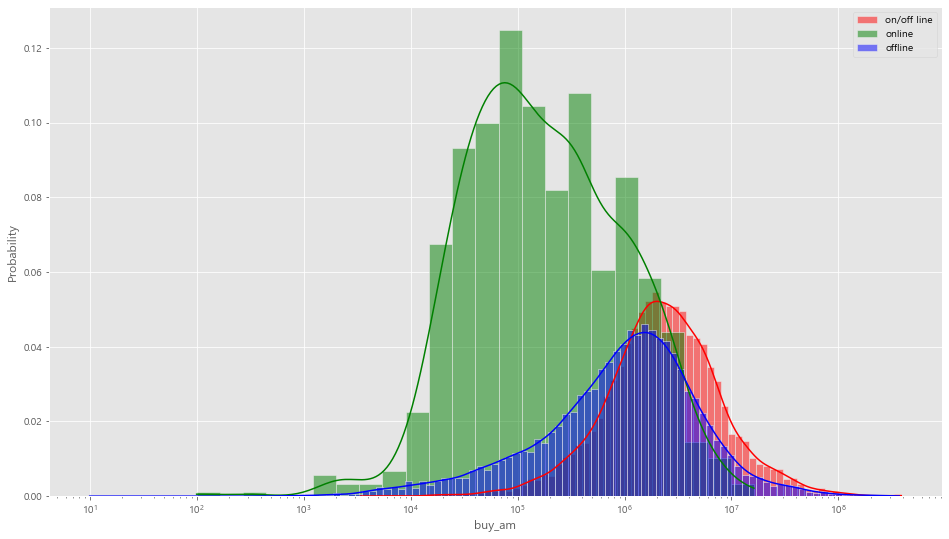

In [20]:
sns.histplot(result_onoff['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="on/off line")
sns.histplot(result_on['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="online")
sns.histplot(result_off['buy_am'], log_scale=True, kde=True, color='blue', alpha=0.5, stat='probability', label="offline")
plt.legend()
plt.show()

In [21]:
from scipy.stats import kstest
import numpy as np

test_stat = kstest(result_onoff['buy_am'], result_on['buy_am'])
test_stat

KstestResult(statistic=0.6291340872882777, pvalue=6.167615603962031e-306)

In [22]:
test_stat = kstest(result_off['buy_am'], result_on['buy_am'])
test_stat

KstestResult(statistic=0.423255355766612, pvalue=3.9097989861462917e-138)

In [23]:
test_stat = kstest(result_onoff['buy_am'], result_off['buy_am'])
test_stat

KstestResult(statistic=0.24175128392548173, pvalue=2.7346970524272835e-296)

총 금액 사용량 ks test p-value가 0에 가까운 값이다. 즉 온라인, 오프라인, 온+오프라인인 경우 전부 다른 분포를 가진다고 할 수 있다. 그래프에서 확인 가능하다.

## loyal / unloyal

충성 고객, 비충성 고객 3을 기준으로 나누는 이유

In [24]:
result_royal = result[result["rct_no"]>3] #충성
result_unroyal = result[result["rct_no"]<=3] #비충성

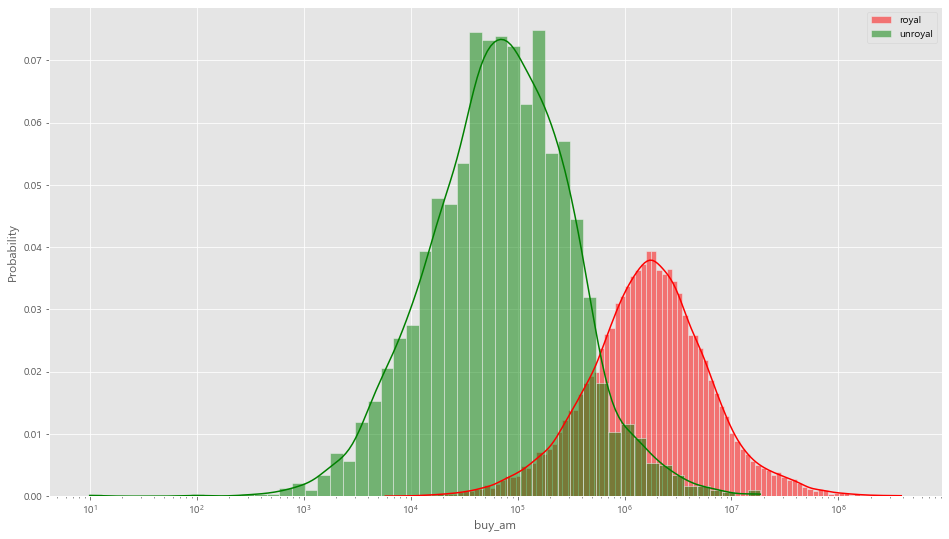

In [25]:
sns.histplot(result_royal['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="royal")
sns.histplot(result_unroyal['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="unroyal")
plt.legend()
plt.show()

In [26]:
test_stat = kstest(result_royal['buy_am'], result_unroyal['buy_am'])
test_stat

KstestResult(statistic=0.7651845793384544, pvalue=0.0)

충성 고객을 주로 구매횟수 3회를 기준으로 나눈다. (Domain지식), 총 금액 사용량 ks test 결과 다른 분포이다.

## vip / unvip

vip를 200,000을 기준으로 나누는 이유 (충성, 비충성 고객 분류보다 조금 더 구체화 하기 위해서)

In [27]:
result_vip = result[result["buy_am"]>200000] #vip
result_unvip = result[result["buy_am"]<=200000] #unvip

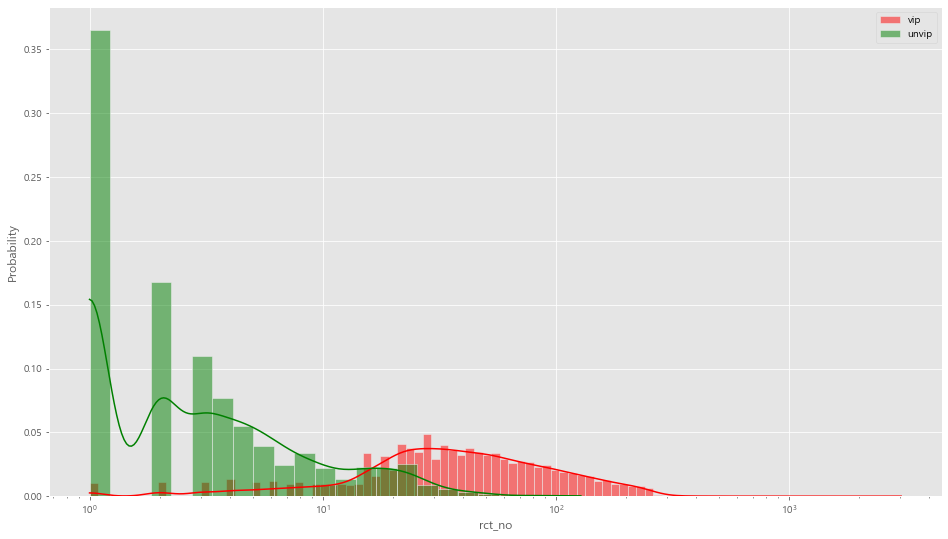

In [28]:
sns.histplot(result_vip['rct_no'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="vip")
sns.histplot(result_unvip['rct_no'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="unvip")
plt.legend()
plt.show()

In [29]:
test_stat = kstest(result_vip['rct_no'], result_unvip['rct_no'])
test_stat

KstestResult(statistic=0.777633306491582, pvalue=0.0)

**클러스터 해석**

0. 온라인만 사용하는 충성&vip 고객 
1. 온라인만 사용하는 충성&unvip 고객
2. 온라인만 사용하는 비충성 고객


3. 온라인, 오프라인 모두 사용하는 충성&vip 고객 
4. 온라인, 오프라인 모두 사용하는 충성&unvip 고객
5. 온라인, 오프라인 모두 사용하는 비충성 고객


6. 오프라인만 사용하는 충성&vip 고객 
7. 오프라인만 사용하는 충성&unvip 고객
8. 오프라인만 사용하는 비충성 고객

In [30]:
result['cluster'].value_counts()

6    13847
3     8239
8     2434
7     1170
2      574
0      287
5      185
4      152
1       29
Name: cluster, dtype: int64

In [31]:
result.head()

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
0,M001248380,여성,30대,Z10,2,38,992100.0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0


In [33]:
# 1 Cluster : 온라인만 사용하는 충성&unvip 고객
result.loc[result["cluster"]==1]

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
287,M023543251,여성,20대,Z16,2,6,105480.0,1
288,M063059486,남성,50대,Z04,2,4,55120.0,1
289,M114374841,여성,30대,Z10,2,4,158290.0,1
290,M120247124,남성,30대,Z17,2,20,197080.0,1
291,M156591412,남성,20대,Z11,2,4,154900.0,1
...,...,...,...,...,...,...,...,...
311,M867637042,남성,30대,Z10,2,5,153300.0,1
312,M873044482,여성,30대,Z11,2,5,178194.0,1
313,M912616576,남성,30대,Z17,2,4,156160.0,1
314,M935051519,여성,50대,Z12,2,17,43400.0,1


In [35]:
result.loc[result["cluster"]==6]

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
9466,M000034966,여성,40대,Z07,1,12,654120.0,6
9467,M000225114,여성,40대,Z17,1,78,1937700.0,6
9468,M000261625,여성,40대,Z17,1,48,6052700.0,6
9469,M000350564,여성,60대,Z10,1,29,9630400.0,6
9470,M000419293,여성,40대,Z17,1,39,1833500.0,6
...,...,...,...,...,...,...,...,...
23308,M999441814,여성,50대,Z08,1,5,282200.0,6
23309,M999468256,여성,70대,Z06,1,19,438960.0,6
23310,M999515910,남성,40대,Z05,1,33,7119795.0,6
23311,M999673157,남성,30대,Z10,1,17,2851370.0,6


# 적절한 파생변수란 무엇일까?
---

1. 고객의 특성을 가장 잘 나타내는 변수
    - 성별, 나이, 지역, 온/오프라인, 영수증 개수, 구매 금액 등?
    - 어떤 유통사에서 구매를 가장 많이 하는가?
    - 유통사별 이용 비율
    - 가장 많이 구매한 품목

## 1. On/Offline의 구분
---

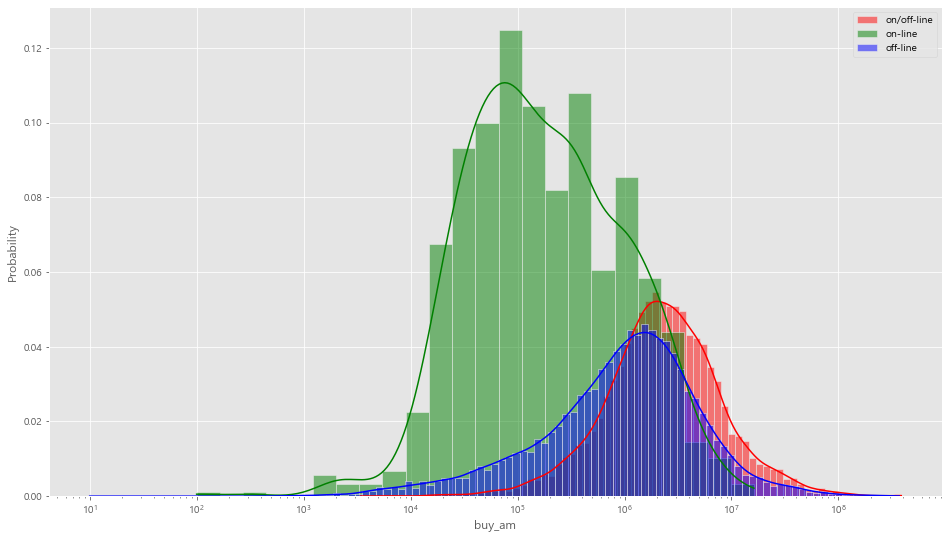

In [38]:
sns.histplot(result_onoff['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="on/off-line")
sns.histplot(result_on['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="on-line")
sns.histplot(result_off['buy_am'], log_scale=True, kde=True, color='blue', alpha=0.5, stat='probability', label="off-line")
plt.legend()
plt.show()

In [43]:
# -- 금액 비율
total = sum(result_onoff['buy_am'].values.tolist() + result_off['buy_am'].values.tolist() + result_on['buy_am'].values.tolist())
print(f"Ratio of ON-OFF : {sum(result_onoff['buy_am'])/total}")
print(f"Ratio of OFF : {result_off['buy_am'].sum()/total}")
print(f"Ratio of ON : {result_on['buy_am'].sum()/total}")

Ratio of ON-OFF : 0.445750927236878
Ratio of OFF : 0.5487245111756761
Ratio of ON : 0.005524561587445953


In [44]:
# -- 고객 비율
total = result["cust"].nunique()
print(f"Ratio of ON-OFF : {result_onoff['cust'].nunique()/total}")
print(f"Ratio of OFF : {result_off['cust'].nunique()/total}")
print(f"Ratio of ON : {result_on['cust'].nunique()/total}")

Ratio of ON-OFF : 0.31860905747297247
Ratio of OFF : 0.6483263365159565
Ratio of ON : 0.03306460601107107


In [47]:
result_off["cust"].nunique()

17451

In [54]:
df_onoff_cust = df_pdde.loc[df_pdde["cust"].isin(result_onoff["cust"].values.tolist())]


In [58]:
df_onoff_pivot = pd.pivot_table(data = df_onoff_cust,
               index="cust",
               columns="chnl_dv",
               values="rct_no",
               aggfunc="count")
df_onoff_pivot.reset_index(inplace=True)
df_onoff_pivot["sum_ch"] = df_onoff_pivot[1]+df_onoff_pivot[2]
df_onoff_pivot["ratio_off"] = df_onoff_pivot[1]/df_onoff_pivot["sum_ch"]
df_onoff_pivot["ratio_on"] = df_onoff_pivot[2]/df_onoff_pivot["sum_ch"]
df_onoff_pivot

chnl_dv,cust,1,2,sum_ch,ratio_off,ratio_on
0,M000136117,96,13,109,0.880734,0.119266
1,M000494848,334,63,397,0.841310,0.158690
2,M000621637,170,21,191,0.890052,0.109948
3,M000986912,69,27,96,0.718750,0.281250
4,M001332751,398,1,399,0.997494,0.002506
...,...,...,...,...,...,...
8571,M999105944,27,2,29,0.931034,0.068966
8572,M999180761,44,1,45,0.977778,0.022222
8573,M999599111,32,2,34,0.941176,0.058824
8574,M999770689,298,17,315,0.946032,0.053968


In [59]:
df_onoff_pivot.describe()

chnl_dv,1,2,sum_ch,ratio_off,ratio_on
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,183.091884,46.315065,229.406950,0.796903,0.203097
std,246.267315,102.291895,269.574151,0.260292,0.260292
min,1.000000,1.000000,2.000000,0.002755,0.000080
25%,44.000000,2.000000,64.000000,0.695471,0.018261
50%,110.000000,7.000000,148.000000,0.926606,0.073394
75%,244.000000,37.000000,313.000000,0.981739,0.304529
max,12447.000000,1748.000000,12448.000000,0.999920,0.997245


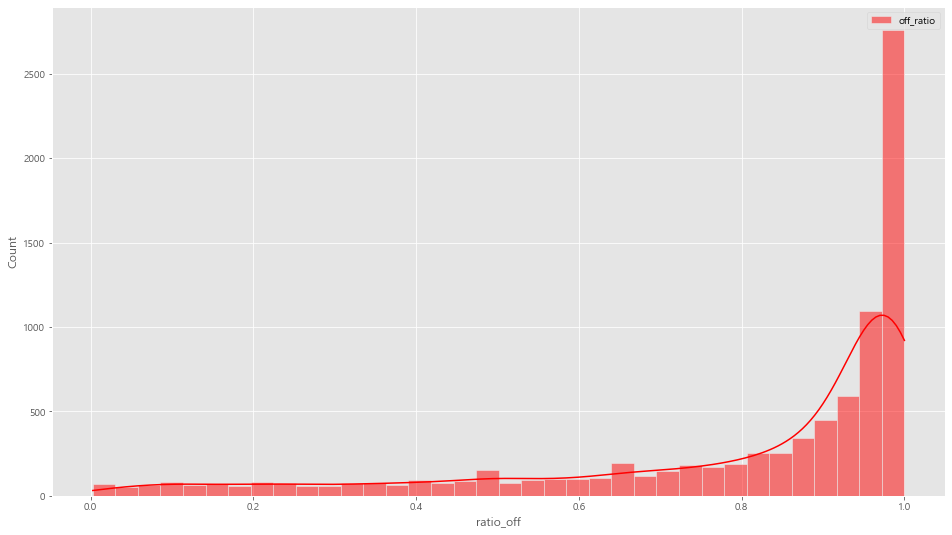

In [61]:
sns.histplot(df_onoff_pivot["ratio_off"], alpha=.5, color="red", kde=True, label="off_ratio")
#sns.histplot(df_onoff_pivot["ratio_on"], alpha=.5, color='green', kde=True, label="on_rartio")
plt.legend()
plt.show()

- on-off 사용 중 on 비중이 큰 사람이 적음

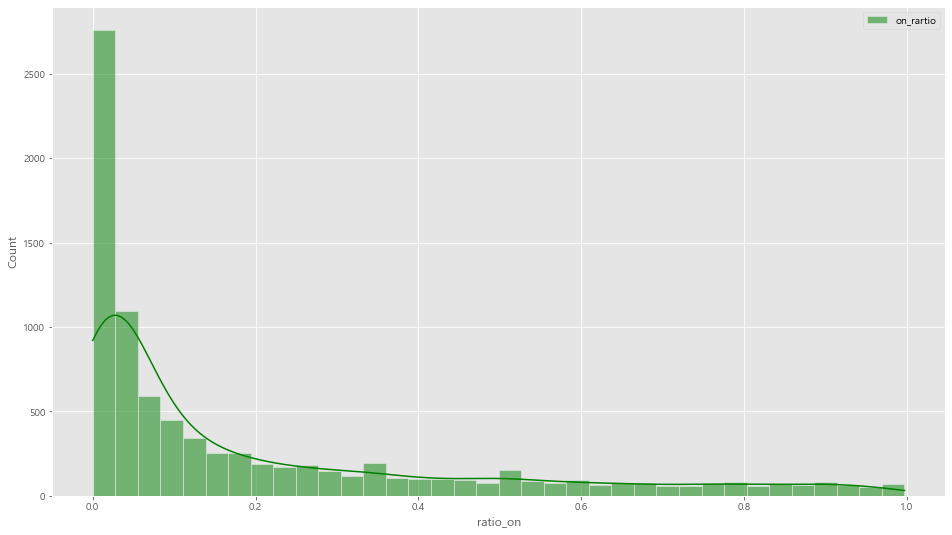

In [62]:
# sns.histplot(df_onoff_pivot["ratio_off"], alpha=.5, color="red", kde=True, label="off_ratio")
sns.histplot(df_onoff_pivot["ratio_on"], alpha=.5, color='green', kde=True, label="on_rartio")
plt.legend()
plt.show()